In [3]:
import cv2, os
from skimage.measure import label, regionprops
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

In [10]:
def get_obj_dis_weight(dis_map, w0=0.8, eps=1e-20):
    """
    获得前景（晶界）权重图,基于正态分布曲线在[-2.58*sigma, 2.58*sigma]处概率密度为99%
    因此每次求取最大值max_dis，反推sigma = max_dis / 2.58
    并根据Unet的原文计算Loss

    Obtain a foreground (grain boundary) weight map based on a normal distribution curve with a probability density of 99% at [-2.58*sigma, 2.58*sigma]
  So each time you get the maximum value max_dis, and then calculate sigma = max_dis / 2.58
  finally calculate Loss based on the original paper of U-Net
    """
    max_dis = np.amax(dis_map)
    std = max_dis / 2.58 + eps
    weight_matrix = w0 * np.exp(-1 * pow(dis_map, 2) / (2 * pow(std, 2)))
    return weight_matrix

def get_bck_dis_weight(dis_map, w0=0.8, eps=1e-20):
    """
    获得背景（晶粒内部）权重图   Obtain background (inside grain) weight map
    """
    max_dis = np.amax(dis_map)
    std = max_dis / 2.58 + eps
    weight_matrix = w0 * np.exp(-1 * pow((max_dis - dis_map), 2) / (2 * pow(std, 2)))
    return weight_matrix

def caculate_weight_map(maskAddress, saveAddress='', weight_cof = 1):
    """
    计算真值图对应的权重图  Calculate the weight map corresponding to the mask image
    :param maskAddress:  Address for mask image or np array
    :param saveAddress:  save directory
    :param weight_cof:  weight for class balance plus w0
    :return:  "adaptive_dis_weight" is the weight map for loss   "adaptive_bck_dis_weight_norm" is the weight map for last information
    """
    if isinstance(maskAddress,str):
        mask = Image.open(maskAddress)
    else:
        mask = maskAddress
    mask = mask.resize((1024, 1024), Image.NEAREST)
    mask = np.asarray(mask, np.float32)
    mask_cup = np.zeros(mask.shape, dtype=np.float32)
    ind = {0: 255, 128: 0, 255: 0}
    for k, v in ind.items():
        mask_cup[mask == k] = v
        
    mask_disc = np.zeros(mask.shape, dtype=np.float32)
    ind = {0: 255, 128: 255, 255: 0}
    for k, v in ind.items():
        mask_disc[mask == k] = v 
    labeled, label_num = label(mask, neighbors=4, background=255, return_num=True) # label_num = 2
    image_props = regionprops(labeled, cache=False)
    dis_trf = ndimage.distance_transform_edt(255 - mask)
    adaptive_cup_dis_weight = np.zeros(mask.shape, dtype=np.float32)
    adaptive_disc_dis_weight = np.zeros(mask.shape, dtype=np.float32)
    adaptive_cup_dis_weight = adaptive_cup_dis_weight + (mask_cup / 255) * weight_cof
    adaptive_disc_dis_weight = adaptive_disc_dis_weight + (mask_disc / 255) * weight_cof
    adaptive_bck_dis_weight = np.ones(mask.shape, dtype=np.float32)

    for num in range(1, label_num + 1):
        image_prop = image_props[num - 1]
        bool_dis = np.zeros(image_prop.image.shape)
        bool_dis[image_prop.image] = 1.0
        (min_row, min_col, max_row, max_col) = image_prop.bbox
        temp_dis = dis_trf[min_row: max_row, min_col: max_col] * bool_dis

        adaptive_cup_dis_weight[min_row: max_row, min_col: max_col] = adaptive_cup_dis_weight[min_row: max_row, min_col: max_col] + get_bck_dis_weight(temp_dis) * bool_dis
        adaptive_disc_dis_weight[min_row: max_row, min_col: max_col] = adaptive_disc_dis_weight[min_row: max_row, min_col: max_col] + get_bck_dis_weight(temp_dis) * bool_dis
        adaptive_bck_dis_weight[min_row: max_row, min_col: max_col] = adaptive_bck_dis_weight[min_row: max_row, min_col: max_col] + get_bck_dis_weight(temp_dis) * bool_dis

    # get weight map for loss
    adaptive_cup_dis_weight = adaptive_cup_dis_weight[:, :, np.newaxis]
    adaptive_disc_dis_weight = adaptive_disc_dis_weight[:, :, np.newaxis]
    adaptive_bck_dis_weight = adaptive_bck_dis_weight[:, :, np.newaxis]
    adaptive_dis_weight = np.concatenate((adaptive_bck_dis_weight, adaptive_cup_dis_weight, adaptive_disc_dis_weight), axis=2)

    # get weight for last information
    adaptive_bck_dis_weight = adaptive_bck_dis_weight[:,:,0]
    bck_maxinum = np.max(adaptive_bck_dis_weight)
    bck_mininum = np.min(adaptive_bck_dis_weight)
    adaptive_bck_dis_weight_norm = (adaptive_bck_dis_weight - bck_mininum) / (bck_maxinum - bck_mininum)
    adaptive_bck_dis_weight_norm = (1 - adaptive_bck_dis_weight_norm) * (-7) + 1

    return adaptive_dis_weight, adaptive_bck_dis_weight_norm


n0001.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


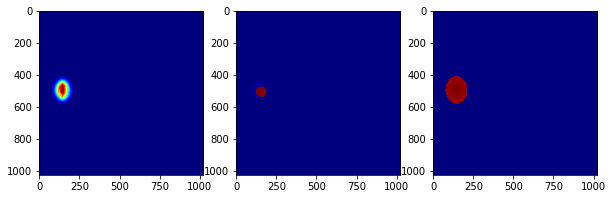

n0002.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


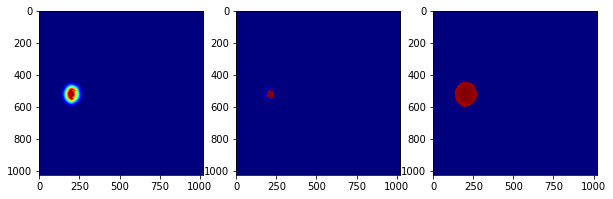

n0003.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


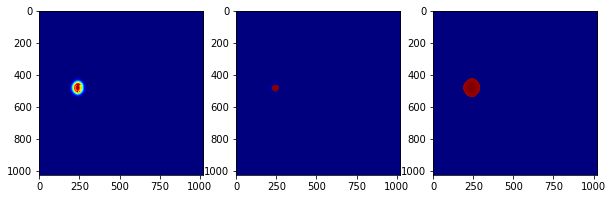

n0004.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


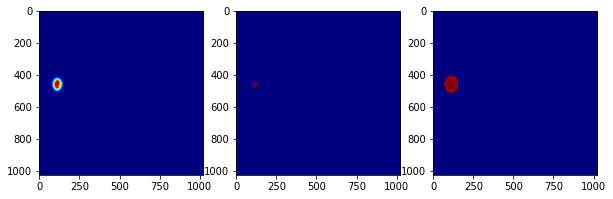

n0005.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


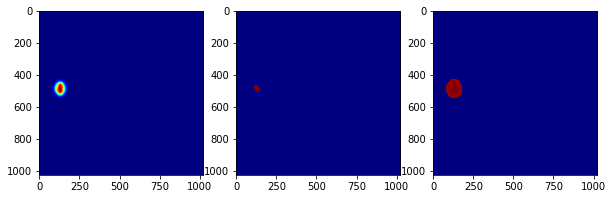

n0006.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


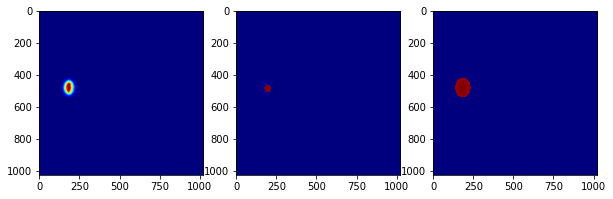

n0007.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


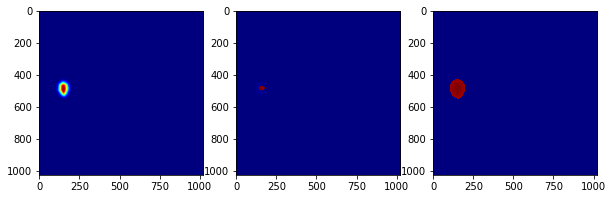

n0008.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


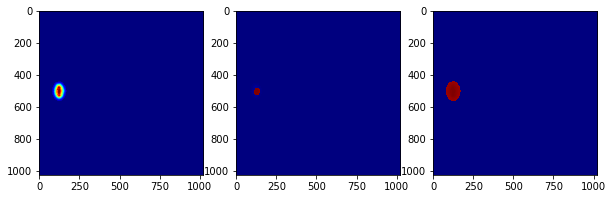

n0009.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


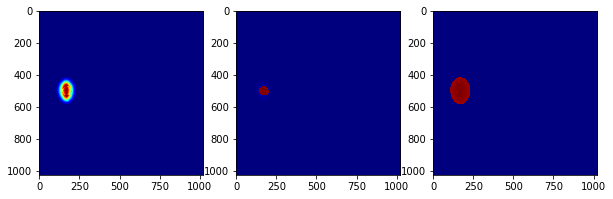

n0010.jpg
adaptive_dis_weight range  30.8   0.0
(1024, 1024, 3)


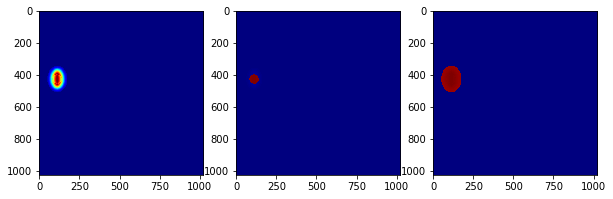

In [11]:
if __name__ == "__main__":
    root = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/'
    list_path = 'E:/dataset-new/source.txt'
    saveAddress = 'E:/dataset-new/source/weight-map'
    img_ids = [i_id.strip() for i_id in open(list_path)]
    for name in img_ids[:10]:
        print(name)
        name_label = name.split('.')[0] + '.bmp'
        maskAddress = os.path.join(root, "level_0.3-0.5/noise_labels_400/%s" % name_label)
        dis_weight, bck_dis_weight_norm = caculate_weight_map(maskAddress, saveAddress= saveAddress, weight_cof=30)
        print("adaptive_dis_weight range ", np.max(dis_weight[:,:,2]), " ", np.min(dis_weight[:,:,2]))
        print(dis_weight.shape)
        #np.save('%s/%s' % (saveAddress, name.split('.')[0] + '.npy'), dis_weight)
        plt.figure(figsize = (10,10))
        plt.subplot(131)
        plt.imshow(dis_weight[:,:,0], cmap = 'jet')
        plt.subplot(132)
        plt.imshow(dis_weight[:,:,1], cmap = 'jet')
        plt.subplot(133)
        plt.imshow(dis_weight[:,:,2], cmap = 'jet')
        plt.show() 
 

In [6]:
root = 'D:/Projects/pOSAL-master/data/Drishti-GS-new/target/pseudo_label_folder_name'
save = 'D:/Projects/pOSAL-master/data/Drishti-GS-new/target/results_ssl_target'
filelist = os.listdir(root)
for i in range(1,len(filelist)):
    file = filelist[i]
    print(i,file)
    gt_mask = Image.open(os.path.join(root,file))
    gt_mask.save(os.path.join(save,'color_'+file.split('.')[0]+'.png'))
    gt_mask = np.asarray(gt_mask, np.float32)
    output_mask = np.asarray(gt_mask, np.float32)
    mask_to_id = {0 : 0, 128 : 1, 255:2}
    for k, v in mask_to_id.items():
        output_mask[gt_mask == k] = v
    output_mask = Image.fromarray(output_mask.astype(np.uint8))
    output_mask.save(os.path.join(save,file.split('.')[0]+'.png'))

1 drishtiGS_002.png
2 drishtiGS_004.png
3 drishtiGS_008.png
4 drishtiGS_010.png
5 drishtiGS_012.png
6 drishtiGS_015.png
7 drishtiGS_016.png
8 drishtiGS_017.png
9 drishtiGS_018.png
10 drishtiGS_022.png
11 drishtiGS_024.png
12 drishtiGS_026.png
13 drishtiGS_031.png
14 drishtiGS_032.png
15 drishtiGS_033.png
16 drishtiGS_035.png
17 drishtiGS_036.png
18 drishtiGS_037.png
19 drishtiGS_038.png
20 drishtiGS_040.png
21 drishtiGS_041.png
22 drishtiGS_042.png
23 drishtiGS_044.png
24 drishtiGS_045.png
25 drishtiGS_046.png
26 drishtiGS_047.png
27 drishtiGS_049.png
28 drishtiGS_051.png
29 drishtiGS_057.png
30 drishtiGS_058.png
31 drishtiGS_060.png
32 drishtiGS_061.png
33 drishtiGS_062.png
34 drishtiGS_063.png
35 drishtiGS_064.png
36 drishtiGS_066.png
37 drishtiGS_068.png
38 drishtiGS_069.png
39 drishtiGS_075.png
40 drishtiGS_076.png
41 drishtiGS_080.png
42 drishtiGS_081.png
43 drishtiGS_084.png
44 drishtiGS_088.png
45 drishtiGS_089.png
46 drishtiGS_090.png
47 drishtiGS_092.png
48 drishtiGS_094.png
4